<h1> Temperature and Salinity Plots </h1>

In [1]:
#Script to create temperature and salinity plots from large scale mean and residual data.

import numpy as np
from tqdm import tqdm
#from largescalefunctions import *
import xarray as xr
import scipy.io as sio
import cmocean as cmocean
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath                  # to draw circle for map
import cartopy                                   # to make map
import cartopy.crs as ccrs               # for map projection
import cartopy.feature as cfeature           # to add land features to map
from datetime import date               # for saving figures with today
import matplotlib.animation as animation
from PIL import Image

In [2]:
#Initializing settings for plots

###### UNIVERSAL PLOT PARAMETERS ######

#### FIGURE SIZE
fig_width  = 3   # inches
fig_height = 3   # inches

#### FONT SIZES
fontsize_large  = 8
fontsize_medium = 6
fontsize_small  = 4

#### MARKER AND LINE SIZES
markersize     = 0.25
axis_linewidth = 1
box_linewidth  = 0.5

#### PLOT COLORS
plot_facecolor          = '#E6F1F1'
overplot_label_color    = '#7B878F'
darker_label_color      = '#C9CCD4'
background_poster_color = '#14417C'
box_color               = '#FA5BBB'

##################################################################
######  Set up Southern Ocean Map  ###############################
##################################################################

def map_southern_ocean_axes_setup(
    ax:                    matplotlib.axes.Axes,
    fig:                   matplotlib.figure.Figure,
    max_latitude:          float = -30,
    add_gridlines:         bool  = True,
    color_land:            bool  = False,
    land_edgecolor:        str   = 'grey',
    land_facecolor:        str   = 'grey',
    fontsize:              float = 10,
    map_facecolor:         str   = 'white',
    coast_linewidth:       float = 0.3,
    gridlines_linewidth:   float = 0.5,
    girdlines_color:       str   = 'grey',
    gridlines_alpha:       float = 0.5,
    longitude_label_color: str   = 'grey',
    latitude_label_color:  str   = 'grey'
) -> None:
    """
    This function sets up the subplot so that it is a cartopy map of the Southern Ocean.
    returns void as the ax and figure objects are pointers not data.
    Args:
        ax  (matplotlib.axes.Axes):     The axis object to add the map to.
        fig (matplotlib.figure.Figure): The figure object for the figure in general.
        add_gridlines (bool):           Whether or not to add gridlines to the plot.
    """
    
    
    ### Limit the map to -40 degrees latitude and below.
    ax.set_extent([-180, 180, -90, max_latitude+0.6], ccrs.PlateCarree())  # set to -29.4 for map out to 30 degrees or -39.4 for map out to 40 degrees
   
    ### Tune the subplot layout
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
    
    ### Make the background of the plot white
    ax.set_facecolor(map_facecolor)

    ### Make SO plot boundary a circle
    def plot_circle_boundary() -> None:
        """
        Make SO plot boundary a circle.
        Compute a circle in axes coordinates, which we can use as a boundary for the map.
        We can pan/zoom as much as we like - the boundary will be permanently circular.
        """
        theta  = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.5  ## could use 0.45 here, as Simon Thomas did
        verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform = ax.transAxes)

    plot_circle_boundary()


    ### Add gridlines (if True)
    if add_gridlines:
        ax.gridlines(color = girdlines_color, alpha = gridlines_alpha, linewidth = gridlines_linewidth)
        
                # specifying xlocs/ylocs yields number of meridian/parallel lines
        dmeridian = 60  # spacing for lines of meridian
        dparallel = 20  # spacing for lines of parallel -- can change this to 10
        num_merid = int(360/dmeridian + 1)
        num_parra = int(180/dparallel + 1)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                          xlocs=np.linspace(-180, 180, num_merid), 
                          ylocs=np.linspace(-90, 90, num_parra), 
                          linestyle="-", linewidth=0.5, color='grey', alpha=gridlines_alpha)
        
        # for label alignment
        va = 'center' # also bottom, top
        ha = 'center' # right, left
        degree_symbol = u'\u00B0'

        # for locations of (meridional/longitude) labels
        lond = np.linspace(-180, 180, num_merid)
        latd = np.zeros(len(lond))

        for (alon, alat) in zip(lond, latd):
            projx1, projy1 = ax.projection.transform_point(alon, max_latitude+1, ccrs.Geodetic())  # set to -29 for map out to 30 degrees or -39 for a map out to 40 degrees
            if alon>-180 and alon<0:
                ha = 'right'
                va = 'center'
            if alon>0 and alon<180:
                ha = 'left'
                va = 'center'
            if np.abs(alon-0)<0.01:
                ha = 'center'
                va = 'bottom'
            if alon==-180:
                ha = 'center'
                va = 'top'
            if (alon<180):
                txt =  ' {0} '.format(str(int(alon)))+degree_symbol
                ax.text(projx1, projy1, txt, va=va, ha=ha, color=latitude_label_color, fontsize=fontsize)
                
        # for locations of (meridional/longitude) labels select longitude: 315 for label positioning
        lond2 = 60*np.ones(len(lond))
        latd2 = np.linspace(-90, 90, num_parra)
        va, ha = 'center', 'center'
        for (alon, alat) in zip(lond2, latd2):
            projx1, projy1 = ax.projection.transform_point(alon, alat, ccrs.Geodetic())
            txt =  ' {0} '.format(str(int(alat)))+degree_symbol
            ax.text(projx1, projy1, txt, va=va, ha=ha, color=longitude_label_color, fontsize=fontsize) 
        
        
    ### Add in coastlines/features
    if color_land:
        ax.add_feature(cfeature.LAND, zorder=0, linewidth = coast_linewidth, edgecolor=land_edgecolor, facecolor=land_facecolor)
    else:
        ax.coastlines(resolution = "50m", linewidth = coast_linewidth)

In [3]:
###### SET WHERE TO SAVE FIGURE

root = '/global/homes/k/kefalc/code/anom_files/'
savepath = '/global/homes/k/kefalc/code/plots/final/'

In [4]:
##open datasets to plot
ds = xr.open_dataset('global/homes/k/kefalc/code/anom_files/final/residualfile_plevel3oxygen_dates16436.0_18261.0_test0.nc')
#beta = xr.open_dataset(root+ 'betaparam_plevel3_dates16436.0_17531.0_test0.nc')
gs = xr.open_dataset('/global/homes/k/kefalc/code/anom_files/final/grid_oxygen_mean_ws500_plevel3_dates16436.0_18261.0_test0.nc')

<h2> Salinity Data Points </h2>

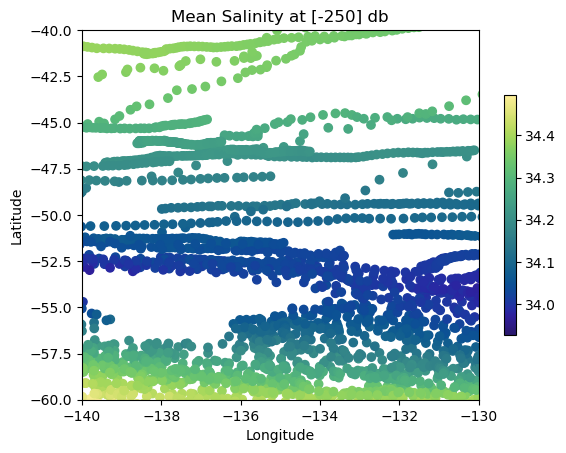

In [5]:
#SINGLE SALINITY MEAN PLOT

#scatter plot
Mean = plt.scatter(ds.longitude,ds.latitude,c=ds.mean_sal, cmap = cmocean.cm.haline)
plt.title('Mean Salinity at ' + str(ds.pressure.values) + ' db')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-140,-130)
plt.ylim(-60,-40)
# plt.savefig(savepath + 'Synth_Salinity_Mean_250db_2015_2017.png')
cbar = plt.colorbar(Mean, shrink = 0.65)


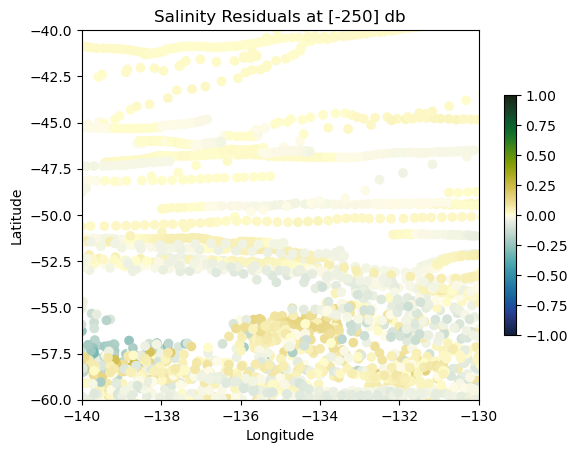

In [6]:
#SINGLE SALINITY RESIDUAL PLOT 
#scatter plot
Anom = plt.scatter(ds.longitude,ds.latitude,c=ds.residuals_sal, cmap = cmocean.cm.delta, vmin = -1, vmax = 1)
plt.title('Salinity Residuals at ' + str(ds.pressure.values) + ' db')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-140,-130)
plt.ylim(-60,-40)
# plt.savefig(savepath + 'Synth_Test_Salinity_Anomaly_250db_2015_2017.png')
cbar = plt.colorbar(Anom, shrink = 0.65)


In [13]:
#SINGLE SALINITY MEAN PLOT PLATE CARREE PROJECTION
ds = xr.open_dataset('/global/homes/k/kefalc/code/anom_files/final/oxy/res/residualfile_plevel4oxygen_dates16436.0_18261.0_test0.nc')
#plt.figure(figsize=(16,12))

projection = ccrs.NearsidePerspective(central_latitude=-90)
data_crs = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
#ax.stock_img() #this fills in background with map image (blue water, white ice etc.)
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
#ax.set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
temp = ax.scatter(ds.longitude,ds.latitude, s=5, c=ds.residuals_bgc, cmap=cmocean.cm.curl, linewidths=0,transform = data_crs, vmin = -4, vmax = 4)
axs = plt.gca()
cbar = plt.colorbar(temp, ax=axs, shrink=0.65)


plt.title('Large Scale Oxygen Residuals at ' + str(ds.pressure.values)+ ' db ', fontsize=10)
plt.show()
#plt.savefig(savepath + 'Test_Salinity_Mean_250db_Map.png')

FileNotFoundError: [Errno 2] No such file or directory: '/global/homes/k/kefalc/code/anom_files/final/TS/res/residualfile_plevel4oxygen_dates16436.0_18261.0_test0.nc'

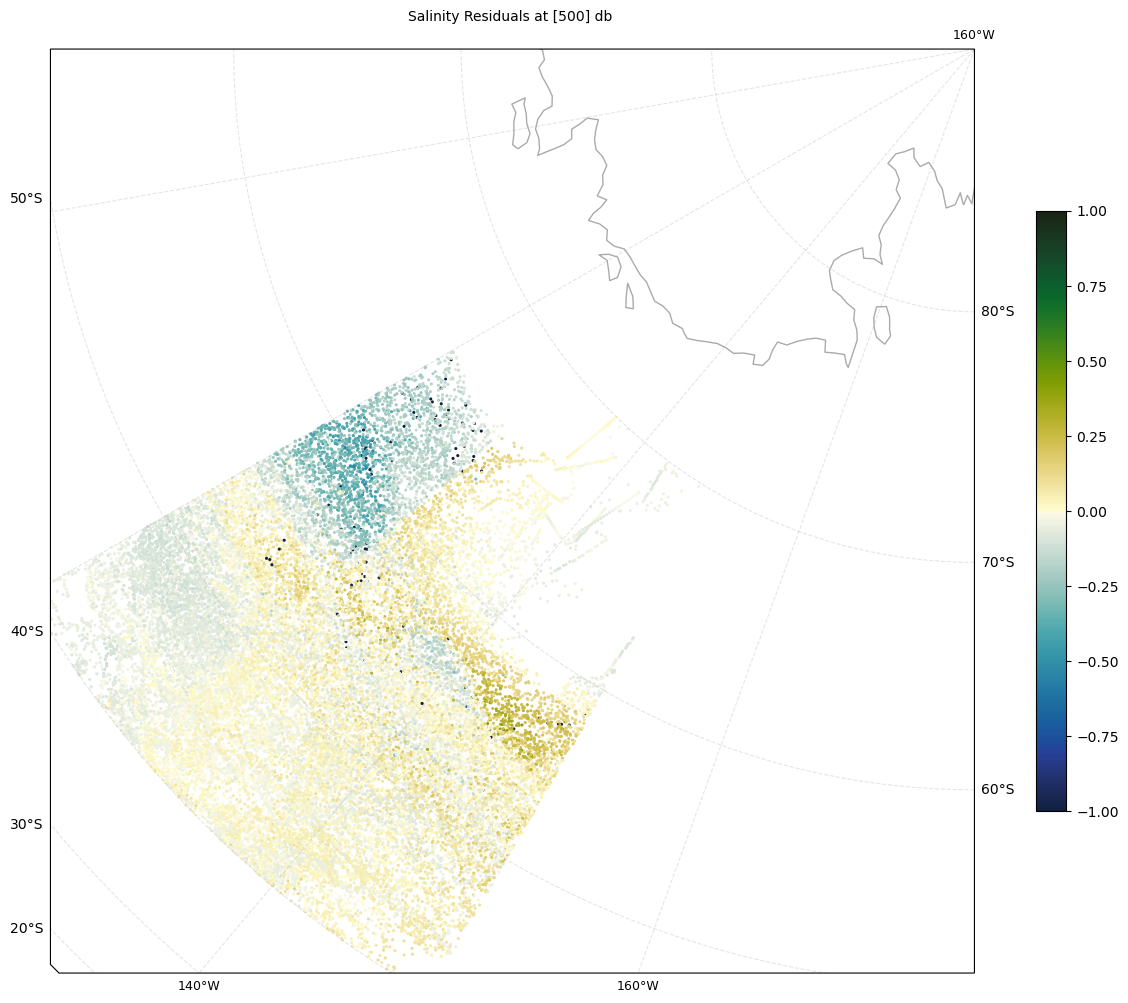

<Figure size 640x480 with 0 Axes>

In [24]:
#SINGLE SALINITY RESIDUAL PLOT PLATE CARREE PROJECTION

plt.figure(figsize=(16,12))

projection = ccrs.NearsidePerspective(central_latitude=-90)
data_crs = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
#ax.stock_img() #this fills in background with map image (blue water, white ice etc.)
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
ax.set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
temp = ax.scatter(ds.longitude,ds.latitude, s=5, c=ds.residuals_sal, cmap=cmocean.cm.delta, vmin = -1, vmax = 1, linewidths=0,transform=data_crs)
axs = plt.gca()
cbar = plt.colorbar(temp, ax=axs, shrink=0.65)


plt.title('Salinity Residuals at ' + str(ds.pressure.values) +' db ', fontsize=10)
plt.show()
plt.savefig(savepath + 'Test_Salinity_Anomaly_250db_Map.png')

<h2> Temperature Data Points </h2>

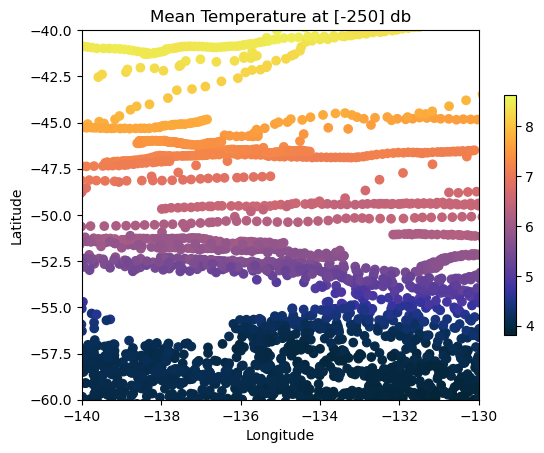

In [7]:
#SINGLE TEMPERATURE MEAN PLOT

#scatter plot
Mean = plt.scatter(ds.longitude,ds.latitude,c=ds.mean_temp, cmap = cmocean.cm.thermal)
plt.title('Mean Temperature at ' + str(ds.pressure.values) + ' db')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-140,-130)
plt.ylim(-60,-40)
# plt.savefig(savepath + 'Synth_Test_Temp_Mean_250db_2015_2017.png')
cbar = plt.colorbar(Mean, shrink = 0.65)

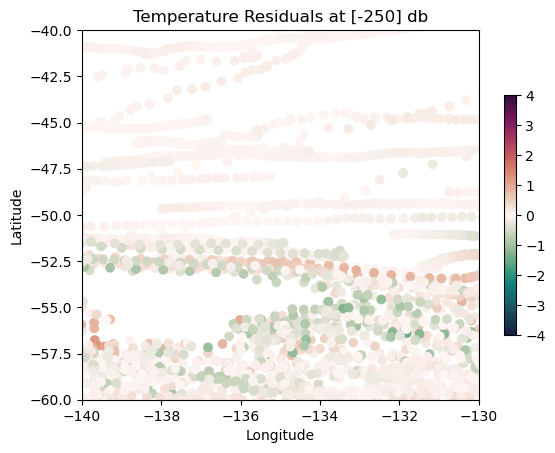

In [8]:
#SINGLE TEMPERATURE RESIDUAL PLOT 
#scatter plot
Anom = plt.scatter(ds.longitude,ds.latitude,c=ds.residuals_temp, cmap = cmocean.cm.curl, vmin = -4, vmax = 4)
plt.title('Temperature Residuals at ' + str(ds.pressure.values) + ' db')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-140,-130)
plt.ylim(-60,-40)
cbar = plt.colorbar(Anom, shrink = 0.65)
# plt.savefig(savepath + 'Synth_Test_Temp_Anomaly_250db_2015_2017.png')

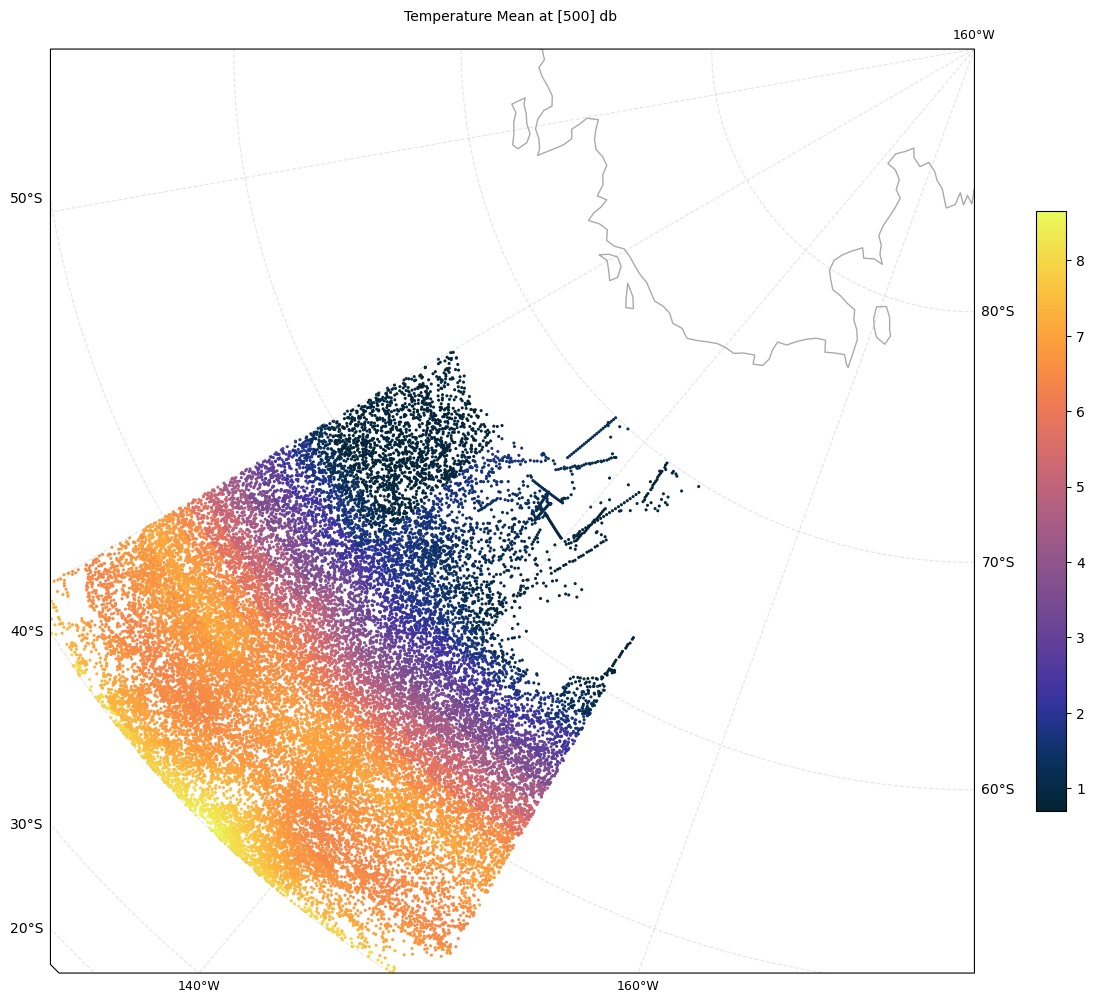

In [29]:
#SINGLE TEMPERATURE MEAN PLOT PLATE CARREE PROJECTION
plt.figure(figsize=(16,12))

projection = ccrs.NearsidePerspective(central_latitude=-90)
data_crs = ccrs.PlateCarree()

ax = plt.axes(projection=projection)
#ax.stock_img() #this fills in background with map image (blue water, white ice etc.)
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
ax.set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
temp = ax.scatter(ds.longitude,ds.latitude, s=5, c=ds.mean_temp, cmap=cmocean.cm.thermal, linewidths=0,transform=data_crs)
axs = plt.gca()
cbar = plt.colorbar(temp, ax=axs, shrink=0.65)


plt.title('Temperature Mean at ' + str(ds.pressure.values) + ' db ', fontsize=10)
plt.show()
#plt.savefig(savepath + 'Test_Temp_Mean_250db_Map.png')

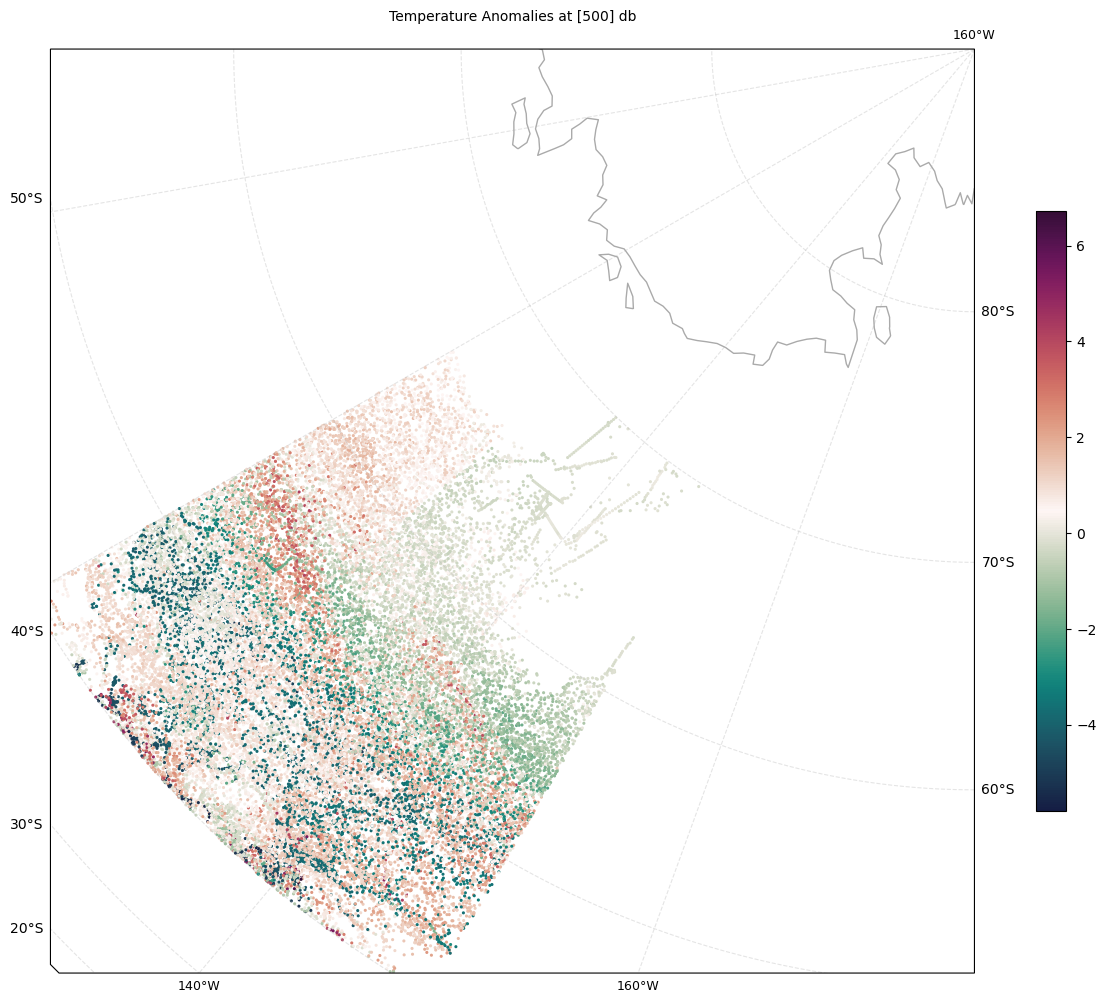

In [31]:
#SINGLE TEMPERATURE RESIDUAL PLOT PLATE CARREE PROJECTION
plt.figure(figsize=(16,12))

projection = ccrs.NearsidePerspective(central_latitude=-90)
data_crs = ccrs.PlateCarree()

maskfile = '/global/homes/k/kefalc/code/gpr-mapping-mean/test_mask.nc'

ax = plt.axes(projection=projection)
#ax.stock_img() #this fills in background with map image (blue water, white ice etc.)
ax.coastlines(alpha=0.3333)
gl = ax.gridlines(draw_labels=True,alpha=0.33, linestyle='--')
ax.set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
temp = ax.scatter(ds.longitude,ds.latitude, s=5, c=ds.residuals_temp, cmap=cmocean.cm.curl, linewidths=0,transform=data_crs)
axs = plt.gca()
cbar = plt.colorbar(temp, ax=axs, shrink=0.65)


plt.title('Temperature Anomalies at ' + str(ds.pressure.values)+ ' db', fontsize=10)
plt.show()
#plt.savefig(savepath + 'Test_Temp_Anomaly_250db_Map.png')

<h2> Subplots for Data Points </h2>

Text(0.5, 1.0, 'Salinity Residuals')

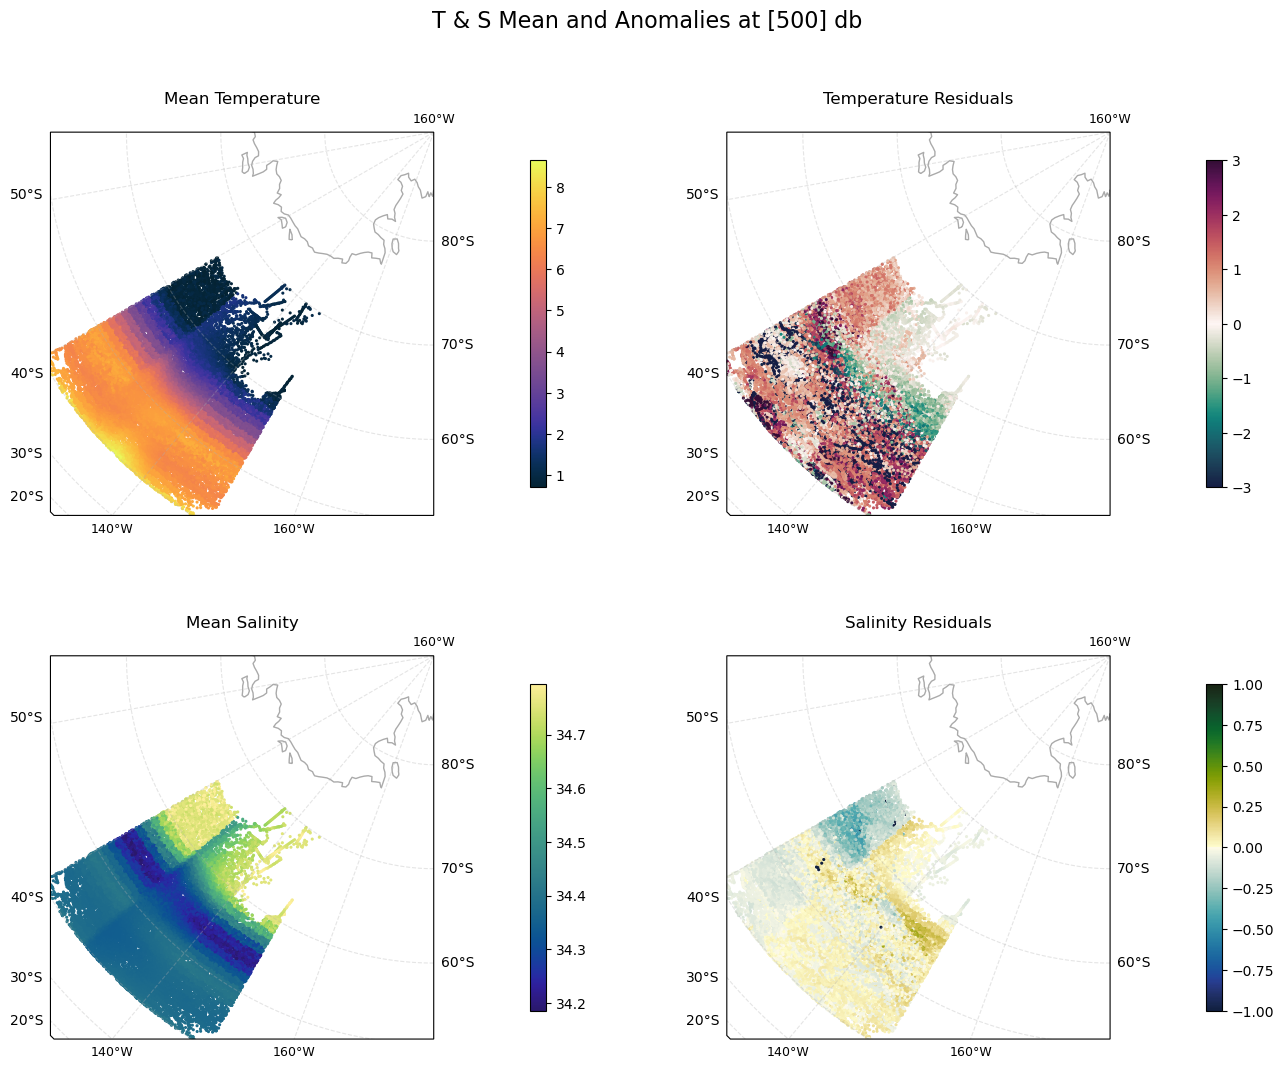

In [34]:
#MEAN AND RESIDUAL SUBPLOTS FOR A SPECIFIC PRESSURE LEVEL PLATE CARREE PROJECTION
fig, axs= plt.subplots(2,2,
                        subplot_kw={'projection': ccrs.NearsidePerspective(central_latitude=-90)},
                        figsize=(16,12))
data_crs = ccrs.PlateCarree()

fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

fig.suptitle('T & S Mean and Anomalies at ' + str(ds.pressure.values) +' db ', fontsize=16)

#mean temperature
axs[0].coastlines(alpha=0.3333)
gl = axs[0].gridlines(draw_labels=True,alpha=0.33, linestyle='--')
axs[0].set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
temp = axs[0].scatter(ds.longitude,ds.latitude, s=5, c=ds.mean_temp, cmap=cmocean.cm.thermal, linewidths=0,transform=data_crs)
#axs[0] = plt.gca()
cbar = fig.colorbar(temp, ax=axs[0], shrink=0.75, pad=0.17)
axs[0].set_title('Mean Temperature')

#temperature residual
axs[1].coastlines(alpha=0.3333)
gl = axs[1].gridlines(draw_labels=True,alpha=0.33, linestyle='--')
axs[1].set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
temp = axs[1].scatter(ds.longitude,ds.latitude, s=5, c=ds.residuals_temp, cmap=cmocean.cm.curl, vmin = -3, vmax=3,linewidths=0,transform=data_crs)
#axs[1] = plt.gca()
cbar = plt.colorbar(temp, ax=axs[1],shrink=0.75, pad=0.17)
axs[1].set_title('Temperature Residuals')

#mean salinity
axs[2].coastlines(alpha=0.3333)
gl = axs[2].gridlines(draw_labels=True,alpha=0.33, linestyle='--')
axs[2].set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
sal = axs[2].scatter(ds.longitude,ds.latitude, s=5, c=ds.mean_sal, cmap=cmocean.cm.haline, linewidths=0,transform=data_crs)
#axs[2] = plt.gca()
cbar = plt.colorbar(sal, ax=axs[2], shrink=0.75, pad=0.17)
axs[2].set_title('Mean Salinity')

#salinity residual
axs[3].coastlines(alpha=0.3333)
gl = axs[3].gridlines(draw_labels=True,alpha=0.33, linestyle='--')
axs[3].set_extent([-140,-130,-90, -30])
gl.xlabel_style = {'size': 9}
# gl.ylabel_style = {'size': 7}
sal = axs[3].scatter(ds.longitude,ds.latitude, s=5, c=ds.residuals_sal, cmap=cmocean.cm.delta, vmin=-1, vmax=1, linewidths=0,transform=data_crs)
#axs[3] = plt.gca()
cbar = plt.colorbar(sal, ax=axs[3], shrink=0.75, pad=0.17)
axs[3].set_title('Salinity Residuals')

#plt.savefig(savepath + 'Test_Subplots_250db_Map.png')

(-60.0, -40.0)

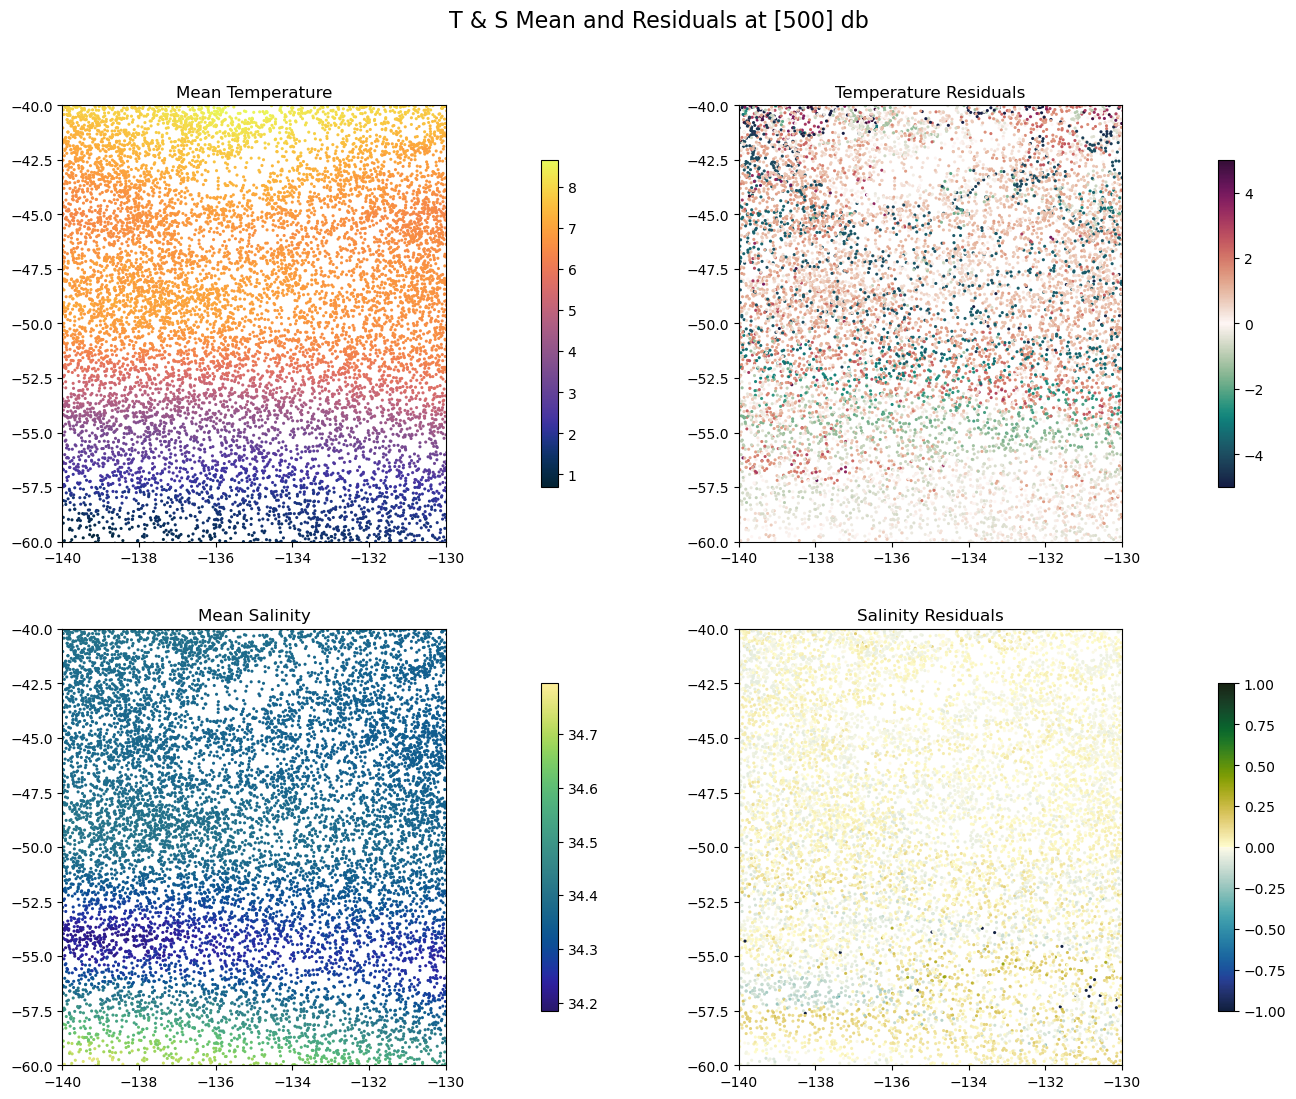

In [35]:
#MEAN AND RESIDUAL SUBPLOTS FOR A SPECIFIC PRESSURE LEVEL SCATTERPLOTS

fig, axs= plt.subplots(2,2,figsize=(16,12))

fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

fig.suptitle('T & S Mean and Residuals at ' + str(ds.pressure.values) + ' db ', fontsize=16)

#mean temperature
temp = axs[0,0].scatter(ds.longitude,ds.latitude, s=5, c=ds.mean_temp, cmap=cmocean.cm.thermal, linewidths=0,)
cbar = fig.colorbar(temp, ax=axs[0,0], shrink=0.75, pad=0.17)
axs[0,0].set_title('Mean Temperature')
axs[0,0].set_xlim(-140,-130)
axs[0,0].set_ylim(-60,-40)


#temperature anomaly
temp = axs[0,1].scatter(ds.longitude,ds.latitude, s=5, c=ds.residuals_temp, cmap=cmocean.cm.curl, vmin = -5, vmax=5,linewidths=0)
cbar = plt.colorbar(temp, ax=axs[0,1],shrink=0.75, pad=0.17)
axs[0,1].set_title('Temperature Residuals')
axs[0,1].set_xlim(-140,-130)
axs[0,1].set_ylim(-60,-40)

#mean salinity
sal = axs[1,0].scatter(ds.longitude,ds.latitude, s=5, c=ds.mean_sal, cmap=cmocean.cm.haline, linewidths=0)
cbar = plt.colorbar(sal, ax=axs[1,0], shrink=0.75, pad=0.17)
axs[1,0].set_title('Mean Salinity')
axs[1,0].set_xlim(-140,-130)
axs[1,0].set_ylim(-60,-40)

#salinity anomaly
sal = axs[1,1].scatter(ds.longitude,ds.latitude, s=5, c=ds.residuals_sal, cmap=cmocean.cm.delta, vmin=-1, vmax=1, linewidths=0)
cbar = plt.colorbar(sal, ax=axs[1,1], shrink=0.75, pad=0.17)
axs[1,1].set_title('Salinity Residuals')
axs[1,1].set_xlim(-140,-130)
axs[1,1].set_ylim(-60,-40)

#plt.savefig(savepath + 'Subplots_250db.png')

<h2> Beta Parameters for T and S </h2>

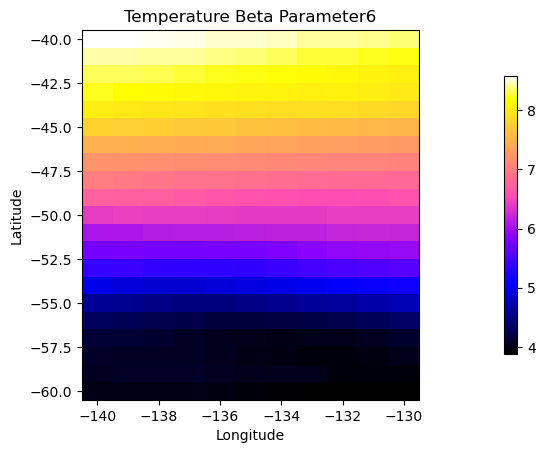

In [9]:
#TEMPERATURE BETAPARAMS
for i in range(5,6):
    bp = plt.pcolormesh(beta.longitude, beta.latitude, beta.betaparam_temp[:,:,i,0])#, vmin=-5, vmax=5)
    cmap = plt.get_cmap('gnuplot2')
    plt.set_cmap(cmap)
    plt.title('Temperature Beta Parameter'+str(i+1))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.xlim(-140,-130)
    #plt.ylim(-60,-40)
    #plt.show()
    
    cbar = plt.colorbar(bp, shrink=0.75, pad=0.17)
    
    #plt.savefig(savepath + 'BP_temp10_'+str(i+1))
    
    #plt.clf()

<h2> Bar Plots </h2>

Text(0.5, 1.0, 'Mean Temperature at [500] db')

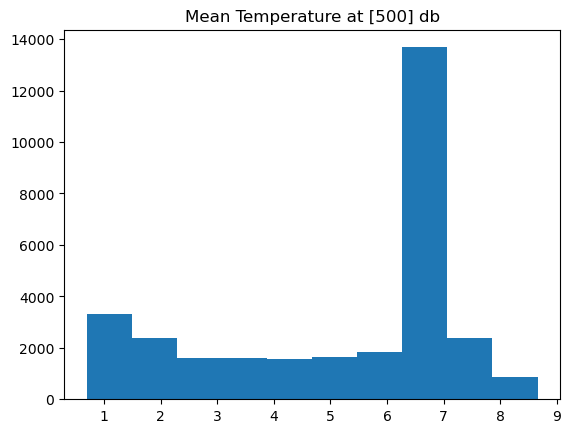

In [38]:
#Mean Temperature
plt.hist(ds.mean_temp)#, bins=np.arange(-2, 7, 0.5), color='mediumseagreen')
plt.title('Mean Temperature at ' + str(ds.pressure.values) + ' db')
#plt.savefig(savepath + 'mean_temp7')

Text(0.5, 1.0, 'Temperature Residuals at [500] db')

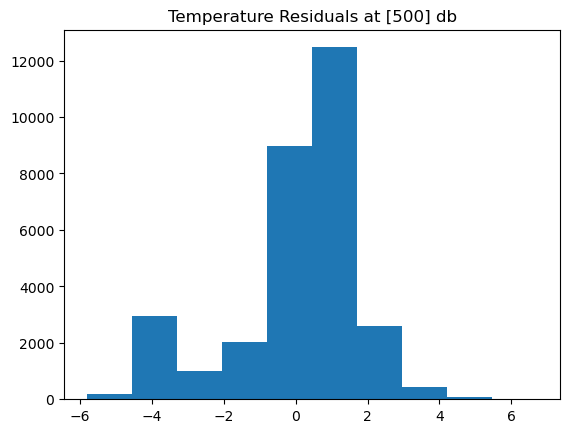

In [40]:
#Temperature Residuals
plt.hist(ds.residuals_temp)#, bins=np.arange(5, 14, 0.5), color='aquamarine')
plt.title('Temperature Residuals at ' + str(ds.pressure.values)+ ' db')
#plt.xlim(3,10)
#plt.ylim(0,50)
#plt.savefig(savepath + 'mean_temp7_anom_out')

Text(0.5, 1.0, 'Mean Salinity at [500]db')

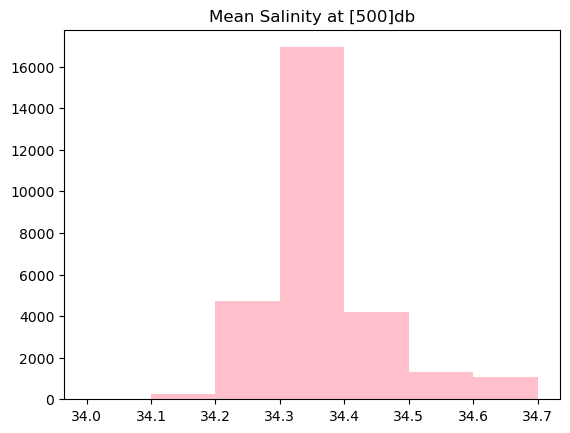

In [42]:
#Mean Salinity
plt.hist(ds.mean_sal, bins=np.arange(34.0, 34.7, 0.1), color='pink')
plt.title('Mean Salinity at ' + str(ds.pressure.values) + 'db')
#plt.savefig(savepath + 'mean_sal250db.png')

Text(0.5, 1.0, 'Outlier Salinity Anomalies at [500] db')

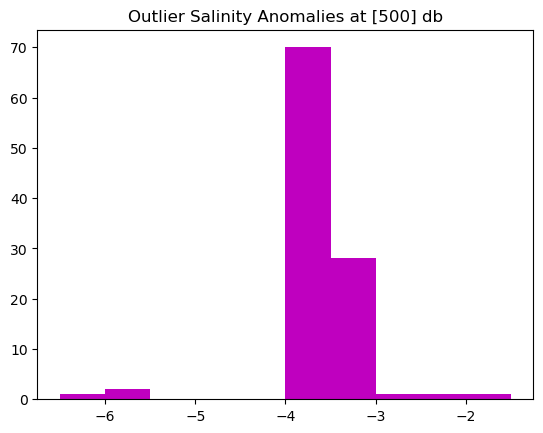

In [44]:
#Salinity Residuals
plt.hist(ds.residuals_sal, bins=np.arange(-6.5, -1, 0.5), color='m')
plt.title('Outlier Salinity Anomalies at ' + str(ds.pressure.values)+ ' db')
#plt.savefig(savepath + 'anom_sal250db_out.png')

<h2> Gridded Dataset </h2>

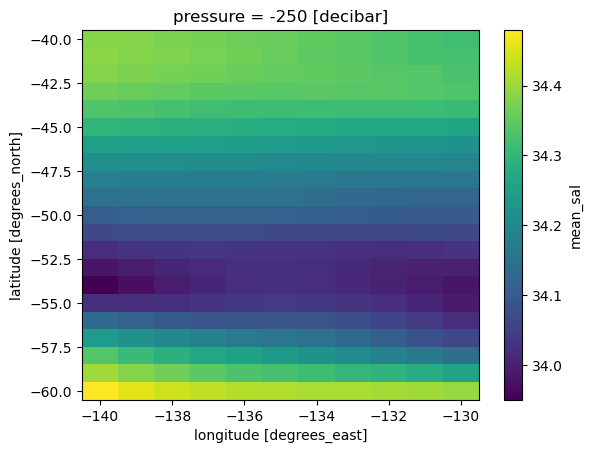

In [10]:
#Mean Salinity
gs.mean_sal.sel(latitude=slice(None, -20)).mean('time').plot(cmap='viridis')
# plt.savefig(savepath + 'synth_seasonalavg_meansal250db_2015_2017.png')

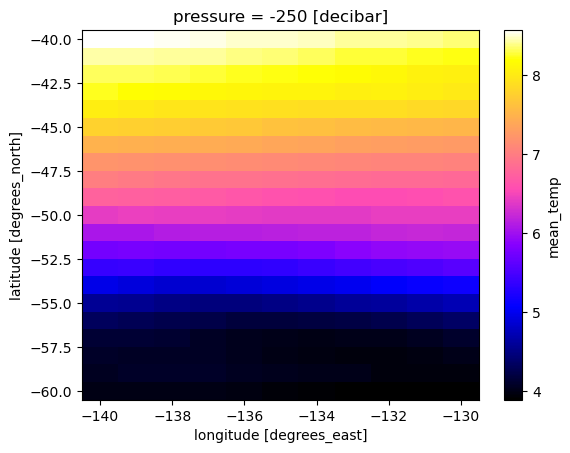

In [11]:
#Mean Temperature
gs.mean_temp.sel(latitude=slice(None, -20)).mean('time').plot(cmap='gnuplot2')
# plt.savefig(savepath + 'synth_seasonalavg_meantemp250db_2015_2017.png')

<h3> Animations </h3>

In [ ]:
##ANIMATED GIF TEMPERATURE

for i in range(0,len(ds.time),10):
    x = gs[dict(time=[i])]
    x.mean_temp.plot(cmap='gnuplot2', vmin=1, vmax=7)
    plt.savefig(savepath + '/animations' + '/PL13_temp/'+str(i)+'.png')
    plt.clf()

In [ ]:
anim_path = savepath + '/animations' + '/PL13_temp/'
anim_fname = 'meantemp_500db'
series_of_images = [Image.open(anim_path +f"{time_i}.png") for time_i in range(0,len(gs.time),10)]
series_of_images[0].save(anim_path+anim_fname+'.gif', save_all=True, append_images=series_of_images[1:], 
                         duration=200, loop=0)

In [ ]:
##ANIMATED GIF SALINITY

for i in range(0,len(ds.time),10):
    x = gs[dict(time=[i])]
    x.mean_sal.plot(cmap='viridis', vmin = 33.90, vmax = 34.32)
    plt.savefig(savepath + '/animations' + '/PL13_sal/'+str(i)+'.png')
    plt.clf()

In [ ]:
anim_path = savepath + '/animations' + '/PL13_sal/'
anim_fname = 'meansal_500db'
series_of_images = [Image.open(anim_path +f"{time_i}.png") for time_i in range(0,len(ds.time),10)]
series_of_images[0].save(anim_path+anim_fname+'.gif', save_all=True, append_images=series_of_images[1:], 
                         duration=200, loop=0)